Импортируем необходимые библиотеки.

Версия mne 0.19.2
Версия seaborn 0.10.0
Версия pyriemann 0.2.5
Версия sklearn 0.22.1

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns

import mne
from mne.io import read_raw_edf
from mne.decoding import CSP


from pyriemann.classification import MDM, TSclassifier
from pyriemann.estimation import Covariances

from sklearn.model_selection import cross_val_score, KFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
os.getcwd()

%matplotlib inline

/home/ambisinistra/miniconda3/envs/mne_pytorch/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/ambisinistra/miniconda3/envs/mne_pytorch/lib/python3.8/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Загружаем данные. Папка directory - папка, содержащяя данны в формате edf.
Список загружаемых данных записывается в переменную eeg_samples.

In [ ]:
directory = '/home/ambisinistra/workspace/EEG/RAW/edf/'

eeg_samples = []

for root, dirs, files in os.walk(directory):
    print (root)
    for file in files:
        if (file.split('.')[-1] == 'edf'):
            eeg_samples.append(read_raw_edf(root + '/' + file, preload = True))

Конкретно в используемых данных не было меток к испытуемому 3 и 6

In [3]:
_ = eeg_samples.pop(6)
_ = eeg_samples.pop(3)

Методы класса mne.rawEdf plot_psd() и plot() позволяют визуализироваться частотную диаграмму
записей и сами записи соответственно

Effective window size : 8.000 (s)


<ipython-input-51-f2c18a207a3c>:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  _ = raw.plot_psd()


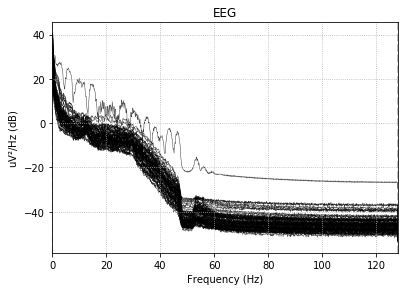

In [51]:
raw = eeg_samples[5]
_ = raw.plot_psd() 
#[raw.plot_psd(picks=i) for i in raw.ch_names]

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB



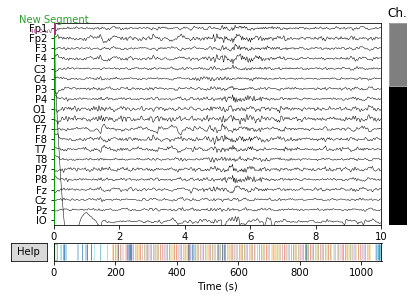

In [52]:
raw.filter(1, 20, method = "iir")
_ = raw.plot()

In [4]:
#triyng smoothing over several epochs if needed

def apply_smoothing(epochs, smoothing=1):
    if smoothing != 1:
        truth = epochs["Truth"]
        new_truth = []
        new_labels = []
        for i in range(0, len(truth), smoothing):
            new_truth.append(truth[i:(i+smoothing)].average().data)
            new_labels.append(0)
        truth = np.stack(new_truth)
        lie = epochs["Lie"]
        new_lie = []
        for i in range(0, len(lie), smoothing):
            new_lie.append(lie[i:(i+smoothing)].average().data)
            new_labels.append(1)
        lie = np.stack(new_lie)
        data = np.concatenate((truth, lie), axis=0)
        labels = np.array(new_labels)
        epochs_data_train = data    #- data.mean())/data.std()
    else:
        epochs_data_train = epochs.get_data() #- epochs.average().data) / epochs.standard_error().data
        labels = (epochs.events[:, 2]  - 2)/7 #catching events with id's 2 and 7
        labels *= -1
        labels += 1
        
    return (epochs_data_train[:,:,75:], labels) #cut before 200ms stimulus

In [5]:
def extract_events_and_epochs(raw, verbose=True):
    #show energies by frequencies
    if verbose:
        _ = raw.plot_psd()
    #applying filtering
    raw.filter(1, 20, method = "iir")
    #show data after filtration
    if verbose:
        _ = raw.plot()
    events = mne.events_from_annotations(raw)

    event_id = dict(Lie=2, Truth=9)

    epochs = mne.Epochs(raw, events[0], event_id, tmin = -0.1, tmax = 0.7, verbose=verbose, preload=True)
    #to pick p300 electrodes add 'picks=["Fz","Pz","Fpz"]'
    
    return (events, epochs)

Effective window size : 8.000 (s)


<ipython-input-31-6c522d8a0b00>:4: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  _ = raw.plot_psd()


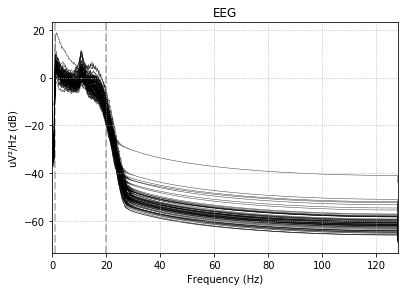

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB



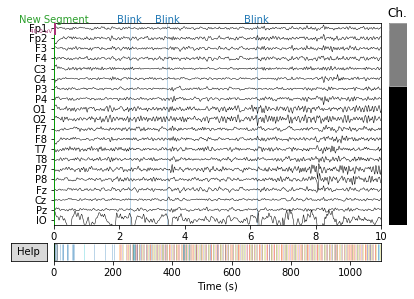

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
151 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 151 events and 206 original time points ...
0 bad epochs dropped


In [44]:
events, epochs = extract_events_and_epochs(raw)

Если извлечь эпози только по электродам Fz,Pz,Fpz то можно увидеть
потенциал p300 на ложных ответах при максимально усреднении.
К сожалению, такие результаты получаются не всегда.

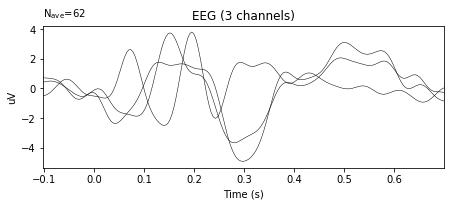

In [53]:
_ = epochs['Lie'].average().plot()

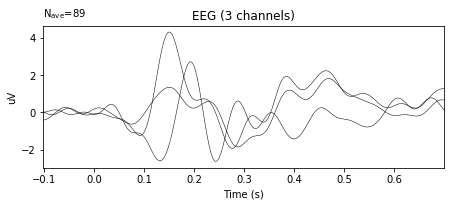

In [54]:
_ = epochs['Truth'].average().plot()

Производим создание объектов классификаторов.

В дальнейшем, классификаторы будут использованы в пайплайне cross_val_score библиотеки scipy,
который помогает автоматизировать настройку классификатора с последующей проверкой его качества.

mdm - minimal distance to mean
clf - логистическая регрессия на римановой дистанции
clf_assembly - логистическая регрессия на общих пространственных паттернах

Обязательна фиксация зерна датчика случайных чисел для воспроизводимости результатов. 

In [6]:
mdm = MDM(metric=dict(mean='riemann', distance='riemann'))

clf = TSclassifier()

# Assemble a classifier
lr = LogisticRegression()
csp = CSP(n_components=4, reg='ledoit_wolf', log=False)
clf_assembly = Pipeline([('CSP', csp), ('LogisticRegression', lr)])

np.random.seed(42)

Присовение переменной DEBUG истинного значения запускает проверку корректности усреднения
ЭЭГ эпох с последнующей визаулизацией, по умолчанию отключена.

Присвоение переменной TRAIN_TEST истинного значения запускает разбиение на тестовую и
тренировочную выборки. При ложном значение проверка классификаторов производится только
на кроссвалидационном разбиении. По умолчанию включена.

Внешний цикл n_patient итерируется по списку eeg_samples, перебирая индекс обращения.
В переменных mdm_score, clf_score, clf_assembly_score записываются точность классификаторов
на каждом количестве усреднений.

Внутренний цикл i итерируется по количеству усреднений. На каждом шаге вызывается
функция apply_smoothing, которая возвращает эпохи и метки классов с заданным количеством
усреднений. В переменную cov_data_train записываются посчитанные ковариационные матрицы,
после чего в пайплайн cross_val_score подаётся тип классификатора, ковариационные матрицы
и тип разбиения (кросвалиадция с тестом или просто кросвалидация).

После прохождения всех итераций внутреннего цикла i список результатов классификаторов
добавляется в mdm_score_final, clf_score_final и clf_assembly_score_final, которые
после всех итераций внешнего цикла представляют собой матрицы размера
[количество испытуемых, количество усреднений]

При хорошей точности работы классификатора, ковариационная матрица записывается в
отдельный список good_cov_matrices для дальнейшей визуализации.

In [ ]:
#transform numpy array back to mne epochs to check transformation consistency
def back_to_epochs(data_for_epochs :np.array, ch_names = [], freq=500): #-> mne.epochs
    if not ch_names:
        ch_names = raw.ch_names #importing ch_names from raw data
    mne_info = mne.create_info(ch_names, sfreq=freq, ch_types=["eeg"]*64)
    new_epochs = mne.EpochsArray(data_for_epochs, mne_info)
    return (new_epochs)
  
DEBUG = False
TRAIN_TEST = True

if TRAIN_TEST:
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
else:
    cv = KFold(10, shuffle=True, random_state=42)
    
mdm_score_final = []
clf_score_final = []
clf_assembly_score_final = []

threshold = 0.8

good_cov_matrices = []

for n_patient in range(len(eeg_samples)):
    print("PATIENT NUMBER {}".format(n_patient))
    
    clf_score = []
    clf_assembly_score = []
    mdm_score = []
    
    events, epochs = extract_events_and_epochs(eeg_samples[n_patient], verbose = False)
    
    for i in range(1, 6):
    
        print ("APPLYING SMOOTHING {}".format(i))
    
        epochs_data_train, labels = apply_smoothing(epochs, smoothing = i)
    
        if DEBUG:
            to_visualize_smoothed_epochs = back_to_epochs(epochs_data_train)
            _ = to_visualize_smoothed_epochs.average().plot()
    
        # compute covariance matrices
        cov_data_train = Covariances(estimator='lwf').transform(epochs_data_train)
    
        # Use scikit-learn Pipeline with cross_val_score function
        scores = cross_val_score(mdm, cov_data_train, labels, cv=cv, n_jobs=4)

        # Printing the results
        class_balance = np.mean(labels == labels[0])
        class_balance = max(class_balance, 1. - class_balance)
        print("MDM Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
        mdm_score.append(np.mean(scores))
    
        # Use scikit-learn Pipeline with cross_val_score function
        scores = cross_val_score(clf, cov_data_train, labels, cv=cv, n_jobs=4)

        # Printing the results
        class_balance = np.mean(labels == labels[0])
        class_balance = max(class_balance, 1. - class_balance)
        print("Tangent space Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
        clf_score.append(np.mean(scores))
        print ("clf_score", clf_score)
    
        scores = cross_val_score(clf_assembly, epochs_data_train, labels, cv=cv, n_jobs=4)

        # Printing the results
        class_balance = np.mean(labels == labels[0])
        class_balance = max(class_balance, 1. - class_balance)
        print("CSP + LDA Classification accuracy: %f / Chance level: %f" % (np.mean(scores), class_balance))
    
        clf_assembly_score.append(np.mean(scores))
        print("clf_assembly_score", clf_assembly_score)
        
        if (clf_score[i-1] > threshold):
            good_cov_matrices.append([n_patient, i, cov_data_train])
        
    mdm_score_final.append(mdm_score)
    clf_score_final.append(clf_score)
    clf_assembly_score_final.append(clf_assembly_score)

Сохранение показателей успешности классификаторов для последующей визуализации.

In [11]:
with open("mdm_score.npy", 'wb') as f:
    np.save(f, np.array(mdm_score_final))
    
with open("clf_score.npy", "wb") as f:
    np.save(f, np.array(clf_score_final))
    
with open("clf_assembly.npy", "wb") as f:
    np.save(f, np.array(clf_assembly_score_final))

In [12]:
with open("mdm_score.npy", "rb") as f:
    mdm_score_final = np.load(f)

with open("clf_score.npy", "rb") as f:
    clf_score_final = np.load(f)
    
with open("clf_assembly.npy", "rb") as f:
    clf_assembly_score_final = np.load(f)

Визуализация успешности классификаторов. При использовании усреднения по пациентам mean(axis=1)
можно увидеть какие результаты получились на каждом испытуемом, при усреднении mean(axis=0)
можно увидеть результаты по количеству усреднений. При обращений по индексу списка можно
рассмотреть результаты каждого испытуемого.

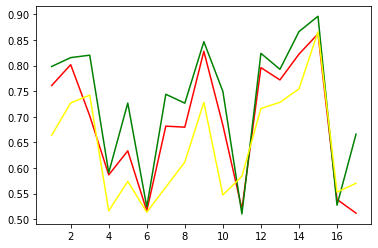

In [14]:
mdm_score = mdm_score_final.mean(axis=1)
clf_score = clf_score_final.mean(axis=1)
clf_assembly_score = clf_assembly_score_final.mean(axis=1)

n = np.array(range(1, len(mdm_score)+1))

plt.plot(n, np.array(mdm_score), label='mdm', color='red')
plt.plot(n, np.array(clf_score), label='clf', color='green')
plt.plot(n, np.array(clf_assembly_score), label='assembly', color='yellow')
plt.show()

In [ ]:
mdm_score = mdm_score_final.mean(axis=0)
clf_score = clf_score_final.mean(axis=0)
clf_assembly_score = clf_assembly_score_final.mean(axis=0)

n = np.array(range(1, len(mdm_score)+1))

plt.plot(n, np.array(mdm_score), label='mdm', color='red')
plt.plot(n, np.array(clf_score), label='clf', color='green')
plt.plot(n, np.array(clf_assembly_score), label='assembly', color='yellow')
plt.show()

In [ ]:
Визуализация ковариационных матриц, на которых получились хорошие результаты.
К сожалению, в отличии от парадигмы экспериментов с определением воображаемых движений
в парадигме p300 ковариационные матрицы не являются интерпретируемыми.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 0
APPLYING SMOOTHING 2


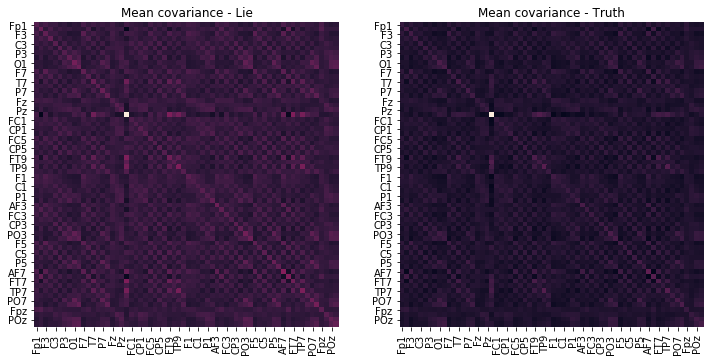

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 0
APPLYING SMOOTHING 4


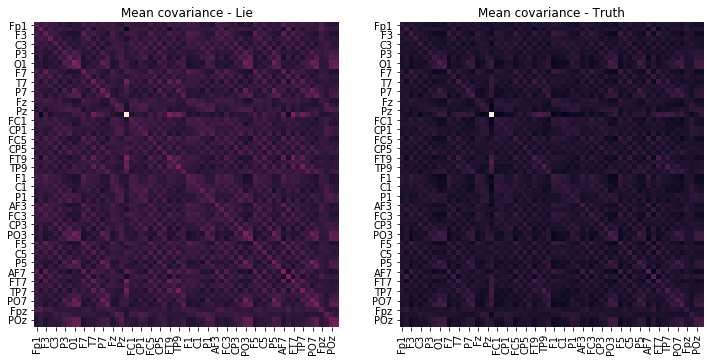

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 0
APPLYING SMOOTHING 5


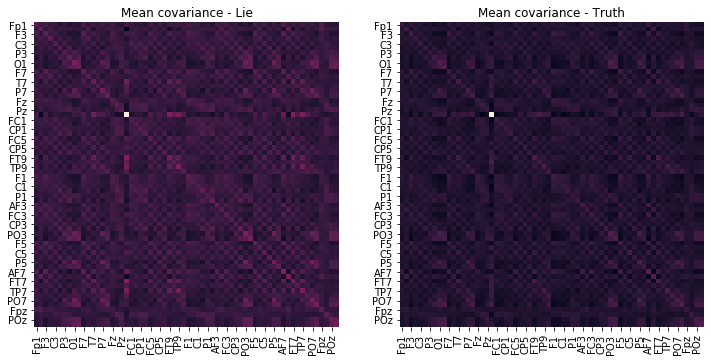

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 1
APPLYING SMOOTHING 3


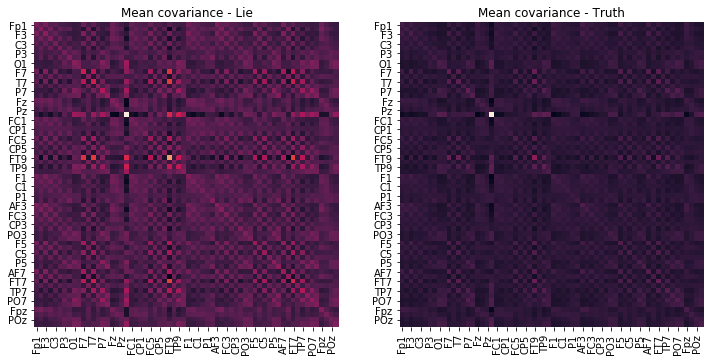

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 1
APPLYING SMOOTHING 4


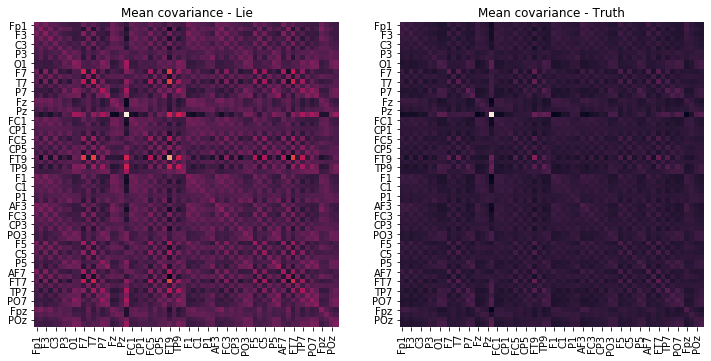

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 1
APPLYING SMOOTHING 5


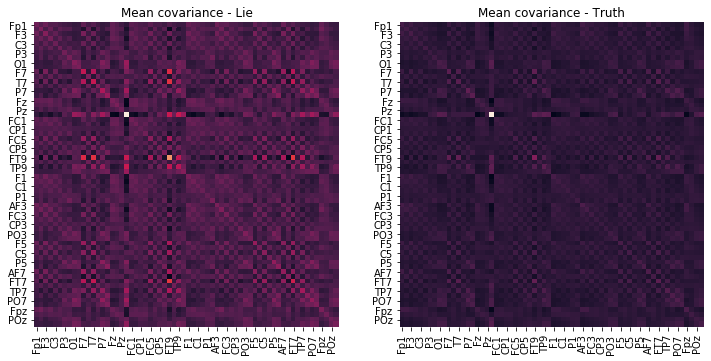

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 2
APPLYING SMOOTHING 2


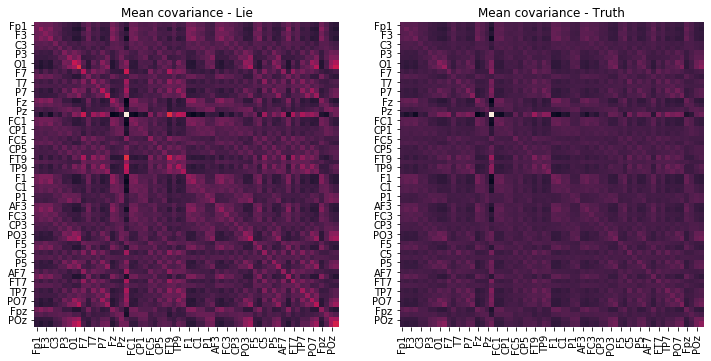

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 2
APPLYING SMOOTHING 3


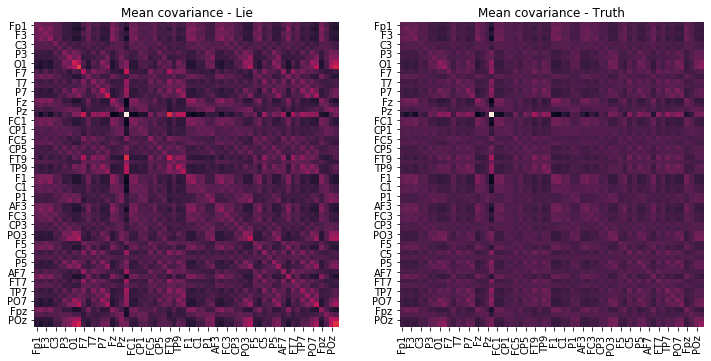

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 2
APPLYING SMOOTHING 4


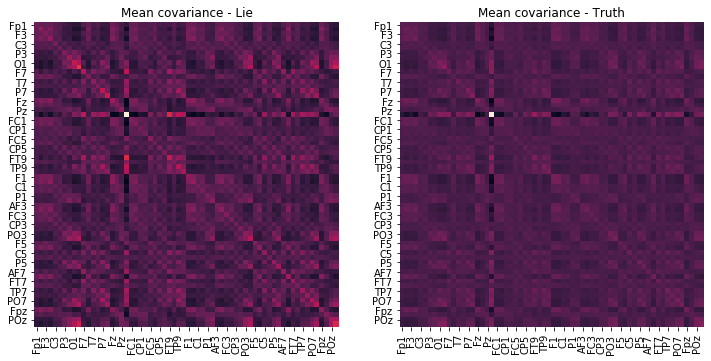

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 4
APPLYING SMOOTHING 2


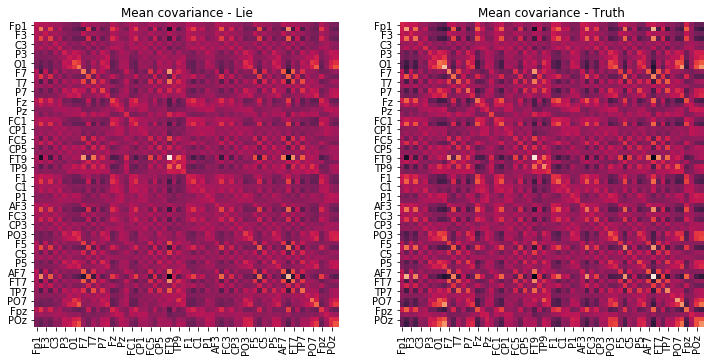

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 8
APPLYING SMOOTHING 2


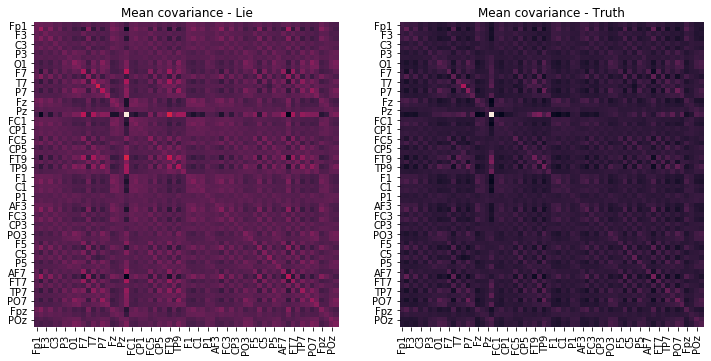

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 8
APPLYING SMOOTHING 3


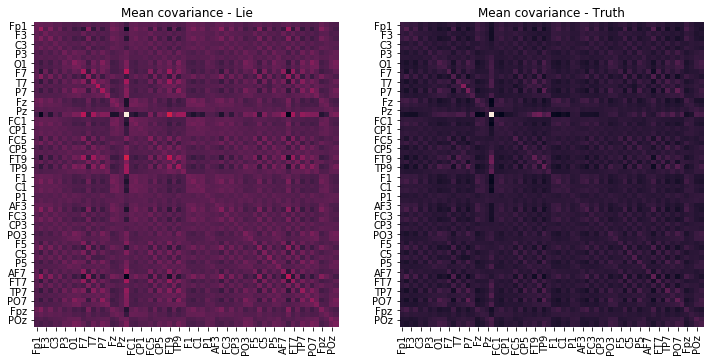

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 8
APPLYING SMOOTHING 4


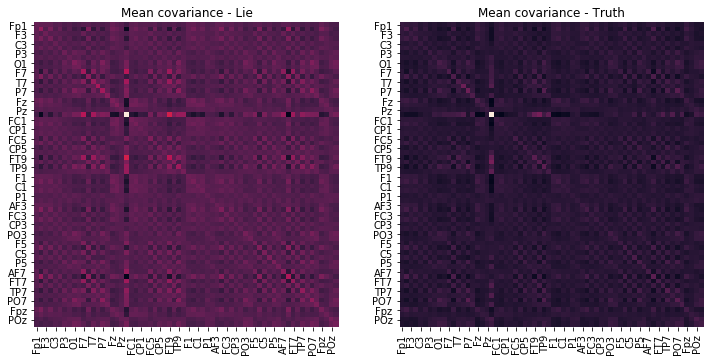

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 9
APPLYING SMOOTHING 4


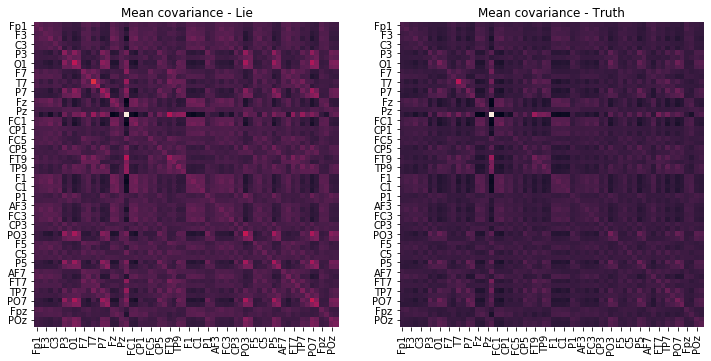

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 11
APPLYING SMOOTHING 1


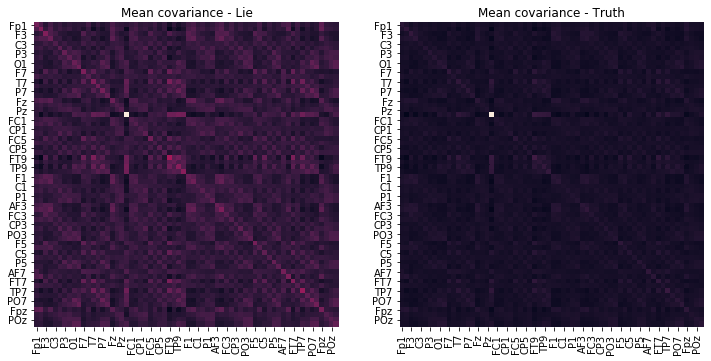

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 11
APPLYING SMOOTHING 2


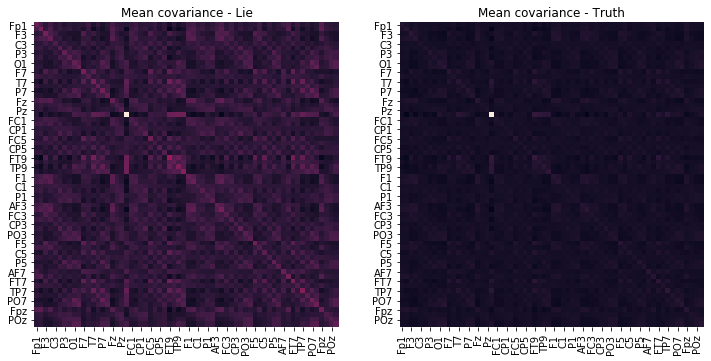

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 11
APPLYING SMOOTHING 3


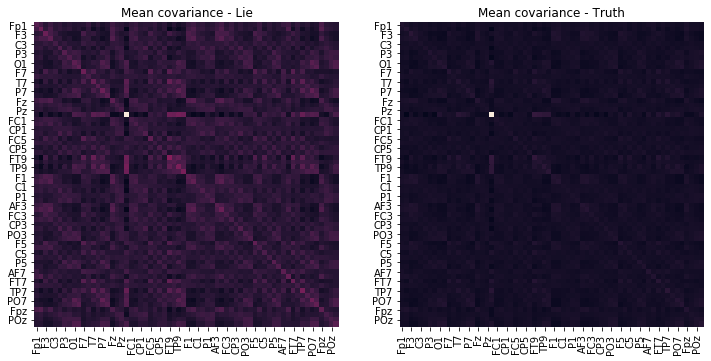

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 11
APPLYING SMOOTHING 5


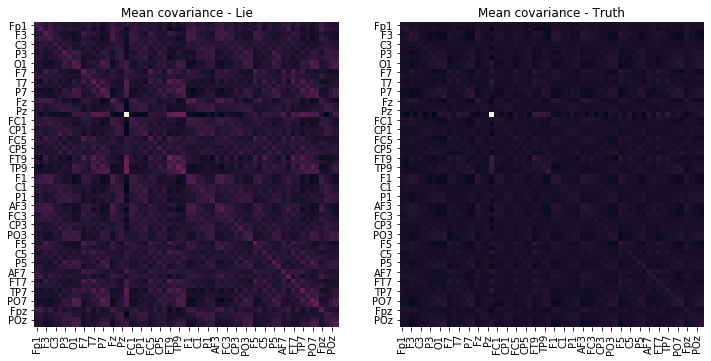

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 12
APPLYING SMOOTHING 2


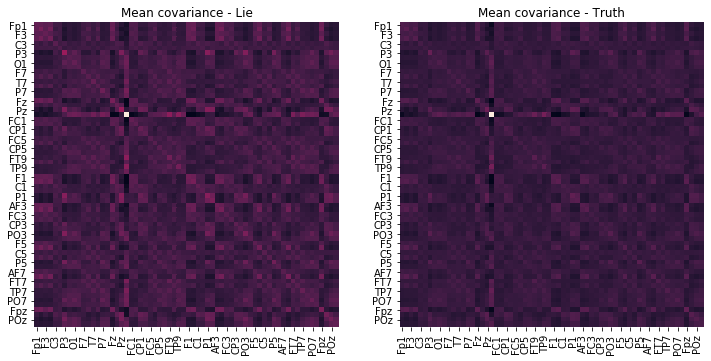

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 12
APPLYING SMOOTHING 5


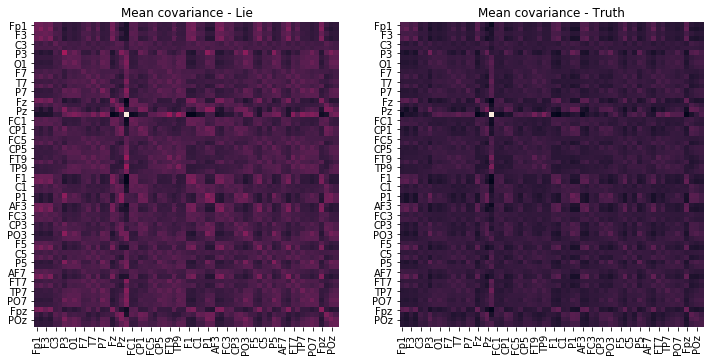

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 13
APPLYING SMOOTHING 2


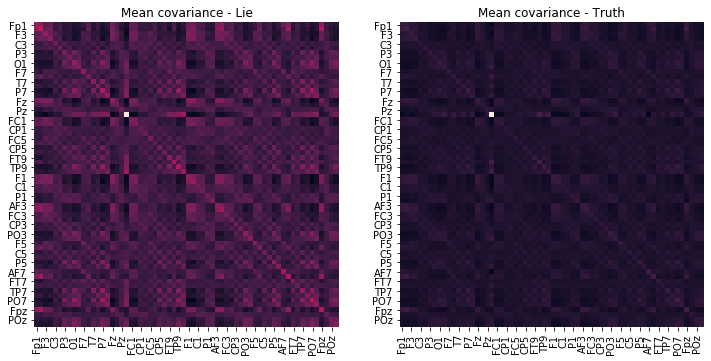

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 13
APPLYING SMOOTHING 3


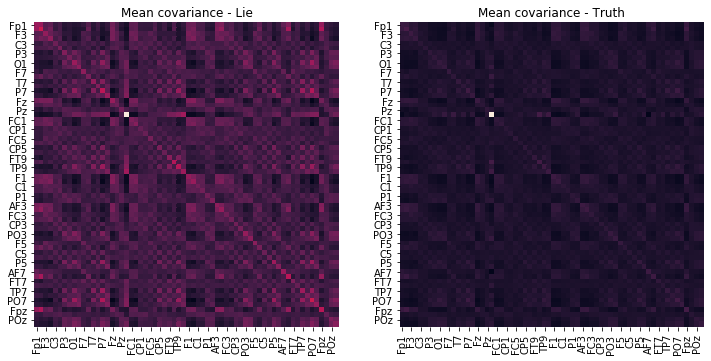

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 13
APPLYING SMOOTHING 4


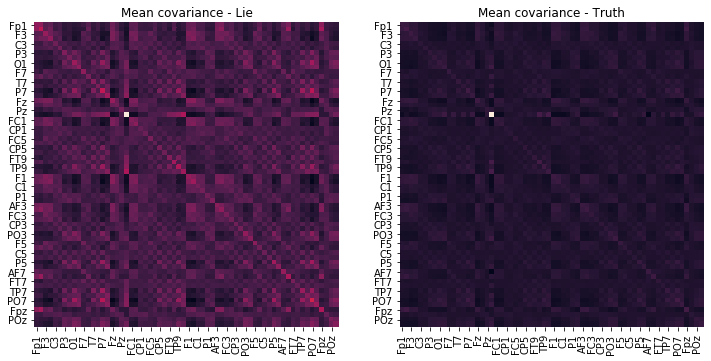

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth', 'Userdefined Artifact']
PATIENT NUMBER 13
APPLYING SMOOTHING 5


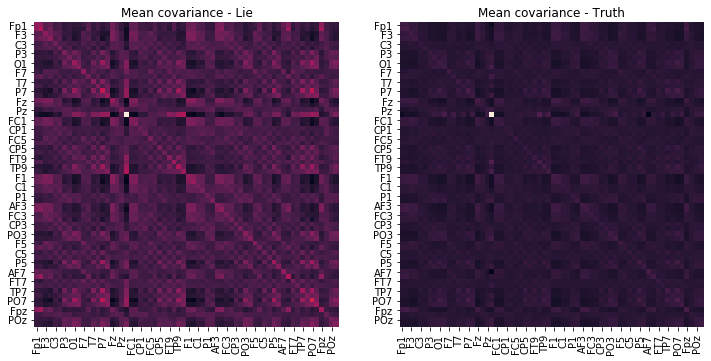

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth']
PATIENT NUMBER 14
APPLYING SMOOTHING 2


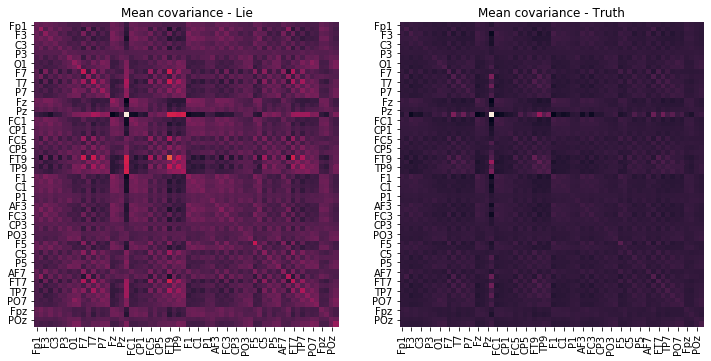

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth']
PATIENT NUMBER 14
APPLYING SMOOTHING 3


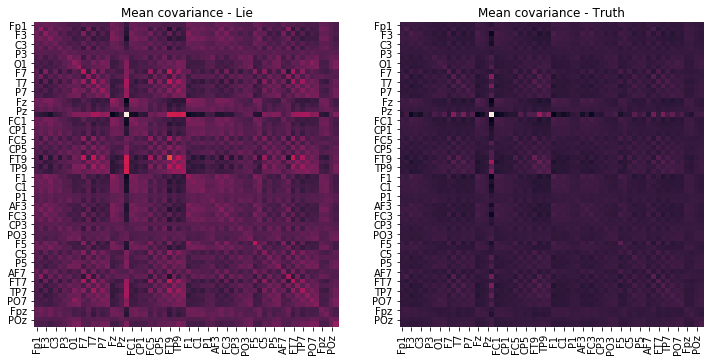

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth']
PATIENT NUMBER 14
APPLYING SMOOTHING 4


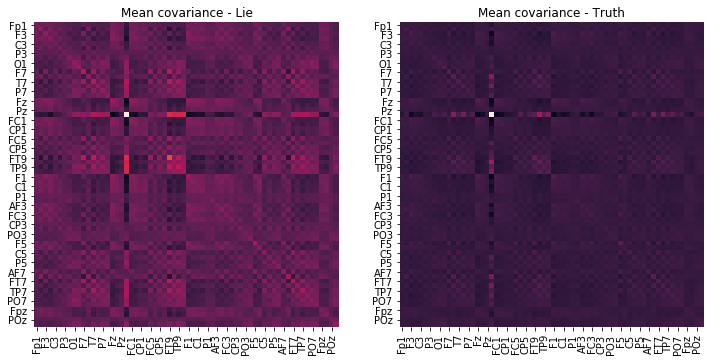

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 20 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 20.00 Hz: -6.02, -6.02 dB

Used Annotations descriptions: ['Blink', 'Lie', 'New Segment', 'S 20', 'S 30', 'S 40', 'S 50', 'S 60', 'Truth']
PATIENT NUMBER 14
APPLYING SMOOTHING 5


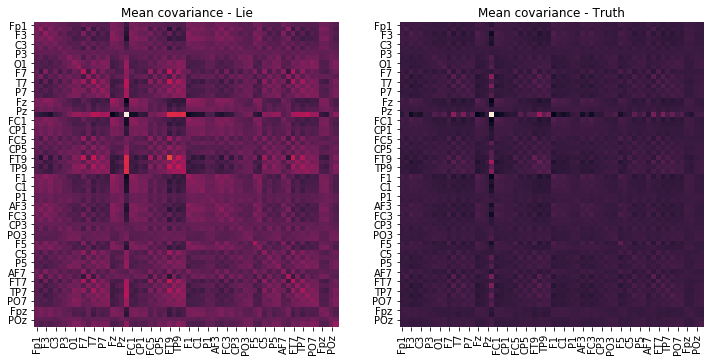

In [12]:
for n_patient, i, _ in good_cov_matrices:

    events, epochs = extract_events_and_epochs(eeg_samples[n_patient], verbose = False)

    epochs_data_train, labels = apply_smoothing(epochs, smoothing = i)

    # compute covariance matrices
    cov_data_train = Covariances(estimator='lwf').transform(epochs_data_train)
    
    print("PATIENT NUMBER {}".format(n_patient))
    print ("APPLYING SMOOTHING {}".format(i))
    mdm = MDM()
    #mdm = TSclassifier()
    mdm.fit(cov_data_train, labels)

    fig, axes = plt.subplots(1, 2, figsize=[12, 12])
    ch_names = [ch.replace('.', '') for ch in epochs.ch_names]

    df = pd.DataFrame(data=mdm.covmeans_[0], index=ch_names, columns=ch_names)
    g = sns.heatmap(df, ax=axes[0], square=True, cbar=False, xticklabels=2,
                yticklabels=2)
    g.set_title('Mean covariance - Lie')

    df = pd.DataFrame(data=mdm.covmeans_[1], index=ch_names, columns=ch_names)
    g = sns.heatmap(df, ax=axes[1], square=True, cbar=False, xticklabels=2,
                yticklabels=2)
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    g.set_title('Mean covariance - Truth')

    # dirty fix
    plt.sca(axes[0])
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')
    plt.show()